# **Installing Modules for Reinforcement Learning with Ray in COLAB**

To start building a reinforcement learning model that can play MultiAgent P2P Energy Trading, you'll need to install several modules in your COLAB environment. Here's a list of the modules and commands you can use to install them:

In [ ]:
!wget http://www.atarimania.com/roms/Roms.rar
!unrar x -o+ /content/Roms.rar >/dev/nul
!python -m atari_py.import_roms /content/ROMS >/dev/nul
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install swig
!pip install box2d
!pip install gymnasium

--2023-11-20 07:33:27--  http://www.atarimania.com/roms/Roms.rar
Resolving www.atarimania.com (www.atarimania.com)... 195.154.81.199
Connecting to www.atarimania.com (www.atarimania.com)|195.154.81.199|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19612325 (19M) [application/x-rar-compressed]
Saving to: ‘Roms.rar’

Roms.rar            100%[===================>]  18.70M   606KB/s    in 32s     

2023-11-20 07:33:59 (596 KB/s) - ‘Roms.rar’ saved [19612325/19612325]

/usr/bin/python3: Error while finding module specification for 'atari_py.import_roms' (ModuleNotFoundError: No module named 'atari_py')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 807.9/807.9 kB 11.8 MB/s eta 0:00:00
  Attempting uninstall: setuptools
    Found existing installation: setuptools 67.7.2
    Uninstalling setuptools-67.7.2:
      Successfully uninstalled setuptools-67.7.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This be

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.9/427.9 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d: filename=Box2D-2.3.2-cp310-cp310-linux_x86_64.whl size=2391309 sha256=5a749769c50c87fea0d3bade4de573e85c8fabf70d0dab1332e884ee12b9068a
  Stored in directory: /root/.cache/pip/wheels/eb/cb/be/e663f3ce9aba6580611c0febaf7cd3cf7603f87047de2a52f9
Successfully built box2d
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 13.9 MB/s eta 0:00:00


Search for the auction, P2P energy trading articles, and the parameters used

In [ ]:
import gymnasium as gym
import os, sys
import argparse
from gymnasium.spaces import Discrete, Box, Tuple, MultiDiscrete, Dict
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import gc


import gym
from gym import spaces
import numpy as np
import random
from gym import Env, spaces
from gym.spaces import Box, Dict, Discrete, MultiBinary, MultiDiscrete
import time
import scipy as sp
import pprint
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Normal
import copy
import random

# Util Functions

In [ ]:
class P2P_Trading(gym.Env):
    def __init__(self, num_agents):
        super(P2P_Trading, self).__init__()

        self.base_production = [
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.004312621, 0.071774334, 0.168192218, 0.257217039,
            0.460218271, 0.570498153, 0.782432671, 1.004840697, 1.154242211, 1.162251363, 1.199524732,
            1.29686675, 1.299331103, 1.29686675, 1.275611687, 1.219239571, 1.147773279, 1.039649711,
            0.919820455, 0.782124626, 0.626254182, 0.410007042, 0.209162118, 0.065305405, 0.004620666,
            0, 0, 0, 0, 0, 0, 0, 0, 0
        ]
        self.base_consumption = [
            1.890533138, 1.79361133, 1.686167065, 1.595204327, 1.505535788, 1.446931715, 1.399057898,
            1.363327038, 1.299266182, 1.232427275, 1.156009985, 1.095003514, 1.036031656, 0.933118909,
            0.866730668, 0.776640083, 0.731532677, 0.702101084, 0.656044224, 0.626890565, 0.618160531,
            0.632455578, 0.602657876, 0.542010441, 0.509068933, 0.546387873, 0.604534497, 0.64672915,
            0.669039453, 0.694250097, 0.719386649, 0.746120278, 0.826147842, 0.956066656, 1.099727799,
            1.245162136, 1.374787823, 1.469763731, 1.518919725, 1.54946759, 1.613802547, 1.677288583,
            1.739266072, 1.795995686, 1.831601717, 1.867379166, 1.868602113, 1.851100494
        ]

        self.trade_length = 30  # Number of days to trade
        self.trade_day = 48 # Number of 30 minute intervals in a day
        self.total_time = self.trade_length * self.trade_day  # Total number of 30 minute intervals
        self.current_time = 0  # Current time in the environment
        self.balance = 1000.00  # Starting balance for each agent

        self.num_agents = num_agents  # Number of agents in the environment
        self.production_multiplier = sp.stats.uniform.rvs(loc=0.8, scale=0.9, size=self.num_agents)  # Generate uniform values for production multiplier
        self.load_multiplier = sp.stats.uniform.rvs(loc=0.8, scale=0.9, size=self.num_agents)  # Generate uniform values for load multiplier

        self.agent_production_profiles = [self.apply_production_variations(self.base_production, self.production_multiplier[i]) for i in range(self.num_agents)]  # Generate production profiles for each agent
        self.agent_consumption_profiles = [self.apply_consumption_variations(self.base_consumption, self.load_multiplier[i]) for i in range(self.num_agents)]  # Generate consumption profiles for each agent

        self.buyFromTNBPrice = 0.57
        self.sellToTNBPrice = 0.15
        self.p2pstart = 14   # 7.00a.m.
        self.p2pend = 34     # 5.00p.m.
        """
        Observation space:
        PV production, load, excess energy, deficit energy, buy (0 or 1), sell (0 or 1),
        Cost From P2P, Cost From TNB, current time (48, 1) - one hot encoding

        """
        # Define action and observation space
        # Define observation space
        self.observation_shape = (self.num_agents,)  # Shape of the observation space
        self.observation_state = None
        self.observation_state_dict = Dict()
        self.observation_space = Dict(
            {
                "PV": spaces.Box(low=0, high=np.inf, shape=self.observation_shape, dtype=np.float32),
                "Load": spaces.Box(low=0, high=np.inf, shape=self.observation_shape, dtype=np.float32),
                "Excess": spaces.Box(low=0, high=np.inf, shape=self.observation_shape, dtype=np.float32),
                "Deficit": spaces.Box(low=0, high=np.inf, shape=self.observation_shape, dtype=np.float32),
                "Buy": spaces.MultiDiscrete([2] * self.num_agents),
                "Sell": spaces.MultiDiscrete([2] * self.num_agents),
                "Time": spaces.Discrete(48),
                "Balance": spaces.Box(low=-np.inf, high=np.inf, shape=self.observation_shape, dtype=np.float32),
                "Prev_Balance": spaces.Box(low=-np.inf, high=np.inf, shape=self.observation_shape, dtype=np.float32),
            }
        )

        # Define action space
        self.action_space = spaces.Box(low=0, high=1, shape=self.observation_shape, dtype=np.float32)

    def reset(self):
        self.current_time = 0 # Reset current time

        self.agent_production_profiles = [self.apply_production_variations(self.base_production, self.production_multiplier[i]) for i in range(self.num_agents)]  # Generate production profiles for each agent
        self.agent_consumption_profiles = [self.apply_consumption_variations(self.base_consumption, self.load_multiplier[i]) for i in range(self.num_agents)]  # Generate consumption profiles for each agent

        # Define your initial state
        pv_initial = np.array([agent_pv[0] for agent_pv in self.agent_production_profiles])  # Initial PV production for each agent
        load_initial = np.array([agent_load[0] for agent_load in self.agent_consumption_profiles])   # Initial load for each agent

        netload_initial = pv_initial - load_initial  # Initial netload for each agent
        excess_initial = np.where(netload_initial > 0, netload_initial, 0) # Initial excess energy for each agent
        deficit_initial = np.where(netload_initial < 0, -netload_initial, 0) # Initial deficit energy for each agent
        # Calculate initial buy and sell flags for each agent
        buy_initial = np.where(netload_initial < 0, 1, 0)
        sell_initial = np.where(netload_initial > 0, 1, 0)
        balance_initial = np.array([self.balance]*self.num_agents)  # Initial balance for each agent
        prev_balance_initial = np.array([self.balance]*self.num_agents) # Initial balance for each agent
        time_initial = 0  # Initial time (0th 30-minute interval)

        initial_state_dict = {
            "PV": pv_initial,
            "Load": load_initial,
            "Excess": excess_initial,
            "Deficit": deficit_initial,
            "Buy": buy_initial,
            "Sell": sell_initial,
            "Balance": balance_initial,
            "Prev_Balance": prev_balance_initial,
            "Time": time_initial,
        }

        self.observation_state_dict = initial_state_dict
        self.observation_state = self._get_observation_space()

        # return state in array and dict format
        return self.observation_state, self.observation_state_dict

    def step(self, action):
        # Perform the action in the environment and return the next state, reward, done flag, and info
        state = self._get_observation_space()

        # Update the state based on the action
        excess = self.observation_state_dict['Excess']  # Excess energy for each agent
        deficit = self.observation_state_dict['Deficit']  # Deficit energy for each agent
        buy = self.observation_state_dict['Buy']  # Buy flag for each agent
        sell = self.observation_state_dict['Sell']  # Sell flag for each agent

        profiles = self.double_auction(excess, deficit, buy, sell, action)
        agent_profits = self.calculate_agent_profit(profiles)
        prev_balance = self.observation_state_dict['Balance']
        self.observation_state_dict['Balance'] = self.observation_state_dict['Balance'] + agent_profits
        self.observation_state_dict['Prev_Balance'] = prev_balance

        # Update the current time
        self.observation_state_dict['Time'] = np.mod(self.observation_state_dict['Time'] + 1, 48)

        if (self.observation_state_dict['Time'] == 0):
            self.agent_production_profiles = [self.apply_production_variations(self.base_production, self.production_multiplier[i]) for i in range(self.num_agents)]
            self.agent_consumption_profiles = [self.apply_consumption_variations(self.base_consumption, self.load_multiplier[i]) for i in range(self.num_agents)]

        pv_profile = np.array([agent_pv[self.observation_state_dict['Time']] for agent_pv in self.agent_production_profiles])  # Initial PV production for each agent
        load_profile = np.array([agent_load[self.observation_state_dict['Time']] for agent_load in self.agent_consumption_profiles])
        netload, excess, deficit, buy, sell = self.calculate_power(pv_profile, load_profile)

        self.observation_state_dict['PV'] = pv_profile
        self.observation_state_dict['Load'] = load_profile
        self.observation_state_dict['Excess'] = excess
        self.observation_state_dict['Deficit'] = deficit
        self.observation_state_dict['Buy'] = buy
        self.observation_state_dict['Sell'] = sell

        next_state = self._get_observation_space()

        self.observation_state = self._get_observation_space()

        # Calculate the reward based on the current state and action
        # reward = self.observation_state_dict['Balance'] - self.observation_state_dict['Prev_Balance']  # Define your reward function
        reward = self.compute_reward(buy, sell, excess, deficit, self.observation_state_dict['Balance'], self.observation_state_dict['Prev_Balance'])

        # Determine if the episode is done
        self.current_time += 1  # Increment the current time
        done = np.array([self.current_time >= self.total_time] * self.num_agents, dtype=np.int64) # Define your termination condition

        # Additional information (optional)
        info = {}

        return state, next_state, reward, done, info

    def compute_reward(self, buy, sell, excess, deficit, curr_balance, prev_balance):
        # Implement reward function here
        reward = np.zeros(shape=(self.num_agents,))

        for i in range(self.num_agents):
            if buy[i] == 1:
                reward[i] = np.abs(deficit[i] * self.buyFromTNBPrice) - np.abs(curr_balance[i] - prev_balance[i])
            elif sell[i] == 1:
                reward[i] = np.abs(curr_balance[i] - prev_balance[i]) - np.abs(excess[i] * self.sellToTNBPrice)
            else:
                reward[i] = 0

        return reward

    def render(self):
        # Implement visualization or logging code here
        pass

    def _get_observation_space_dict(self):
        return self.observation_state_dict

    def _get_observation_space(self):
        state = np.concatenate((
            self.observation_state_dict["PV"],
            self.observation_state_dict["Load"],
            self.observation_state_dict["Excess"],
            self.observation_state_dict["Deficit"],
            self.observation_state_dict["Buy"],
            self.observation_state_dict["Sell"],
            self.observation_state_dict["Balance"],
            self.observation_state_dict["Prev_Balance"],
            np.array([self.observation_state_dict["Time"]])
        ))

        state = state.reshape(1, -1)

        return state

    def _get_observation_space_agent(self, agent_id):
        state = np.concatenate((
            np.array(self.observation_state_dict["PV"][agent_id])[np.newaxis],
            np.array(self.observation_state_dict["Load"][agent_id])[np.newaxis],
            np.array(self.observation_state_dict["Excess"][agent_id])[np.newaxis],
            np.array(self.observation_state_dict["Deficit"][agent_id])[np.newaxis],
            np.array(self.observation_state_dict["Buy"][agent_id])[np.newaxis],
            np.array(self.observation_state_dict["Sell"][agent_id])[np.newaxis],
            np.array(self.observation_state_dict["Balance"][agent_id])[np.newaxis],
            np.array(self.observation_state_dict["Prev_Balance"][agent_id])[np.newaxis],
            np.array([self.observation_state_dict["Time"]])
        ))

        state = state.reshape(1, -1)

        return state

    def apply_production_variations(self, pv_production_list, multiplier=1.0, prob_rain=0.025, prob_cloudy=0.05, num_intervals=48):
        # Convert the list to a NumPy array
        pv_production = np.array(pv_production_list)
        pv_production *= multiplier
        variation = sp.stats.uniform.rvs(loc=0.0, scale=2.0, size=1)[0]

        # Variation due to rain and cloudiness
        for i in range(num_intervals):
            if pv_production[i] > 0:
                # Apply variation due to rain
                if np.random.random() < prob_rain:
                    pv_production[i] *= np.random.uniform(low=0.5, high=1.0)
                # Apply variation due to cloudiness
                if np.random.random() < prob_cloudy:
                    pv_production[i] *= np.random.uniform(low=0.95, high=1.0)

            pv_production[i] *= variation

        return pv_production

    def apply_consumption_variations(self, power_consumption_list, multiplier=1.0):
        power_consumption = np.array(power_consumption_list)
        # Apply variations based on Poisson distribution
        for i in range(len(power_consumption)):
            # Check if the multiplier applies
            # Generate a random value from a Poisson distribution
            variation = sp.stats.uniform.rvs(loc=0.5, scale=0.75, size=1)[0]  # Adjust the parameters as needed
            # Apply the multiplier and variation to the power consumption value
            power_consumption[i] *= variation * multiplier
        return power_consumption

    def calculate_power(self, pv_production, load):
        # Calculate the power for each agent
        """
        PV production @ a certain time for all agents
        Load @ a certain time for all agents
        """

        netload = pv_production - load  # netload for each agent
        excess = np.where(netload > 0, netload, 0) # Initial excess energy for each agent
        deficit = np.where(netload < 0, -netload, 0) # Initial deficit energy for each agent
        # Calculate initial buy and sell flags for each agent
        buy = np.where(netload < 0, 1, 0)
        sell = np.where(netload > 0, 1, 0)

        return netload, excess, deficit, buy, sell

    def limit_within_range(self, action, optimal_value):
        max_value = optimal_value * 1.3  # Calculate the upper limit as 20% above b
        min_value = optimal_value * 0.7  # Calculate the lower limit as 20% below b

        # Limit the value of a within the specified range
        action_clip = np.clip(action, min_value, max_value, dtype=np.float64)

        return action_clip

    # Residential Tariff function to calculate cost from input energy
    def residential_tariff(self, power):
        # Input: energy in kWh
        # Output: Price in RM
        totalcost = 0.
        tariffPrice = [0.218,0.334,0.516,0.546,0.571]
        tariffRange = [200,100,300,300]
        for i in range(0,4):
            if power > 0:
                totalcost += tariffRange[i] * tariffPrice[i]
                power = power - tariffRange[i]
                if power < 0:
                    totalcost -= tariffRange[i] * tariffPrice[i]
                    power = power + tariffRange[i]
                    break
            if i == 3:
                i += 1
        totalcost += power * tariffPrice[i]
        return totalcost

    def double_auction(self, excess, deficit, buy, sell, action):
        total_excess = np.sum(excess)
        total_deficit = np.sum(deficit)

        buy = buy.astype(int)
        sell = sell.astype(int)
        # print(f'Buy: {buy}\n')
        # print(f'Sell: {sell}\n')
        # print(f'Excess: {excess} type: {excess.dtype}\n')
        # print(f'Deficit: {deficit} type: {excess.dtype}\n')

        if total_excess == total_deficit:
            # scenario 1
            optimalBuyPrice = (self.buyFromTNBPrice + self.sellToTNBPrice)/2
            optimalSellPrice = (self.buyFromTNBPrice + self.sellToTNBPrice)/2
        elif total_excess > total_deficit:
            # scenario 2
            optimalBuyPrice = (self.buyFromTNBPrice + self.sellToTNBPrice)/2
            optimalSellPrice = ((optimalBuyPrice * total_deficit) + (self.sellToTNBPrice * (total_excess - total_deficit))) / total_excess
        elif total_excess < total_deficit:
            # scenario 3
            optimalSellPrice = (self.buyFromTNBPrice + self.sellToTNBPrice)/2
            optimalBuyPrice = ((optimalSellPrice * total_excess) + (self.buyFromTNBPrice * (total_deficit - total_excess))) / total_deficit

        # print(f'Total Excess: {total_excess}\n')
        # print(f'Total Deficit: {total_deficit}\n')
        # print(f'Optimal Buy Price: {optimalBuyPrice}\n')
        # print(f'Optimal Sell Price: {optimalSellPrice}\n')

        # Type: buy (1) or sell (0), Price, TotalBuyP2P or TotalSellP2P, TotalBuyTNB or TotalSellTNB
        # users = np.array([0 ,0, 0, 0], dtype=np.float64)
        # users = np.tile(users, (self.num_agents, 1))
        users = np.zeros([0, 4])
        # initialising buy and sell list
        # columns: [price, amount, user]
        sell_list = np.zeros([0,3])
        buy_list = np.zeros([0,3])

        # initialising quantity matching list
        # row 1: seller, row2: buyer
        # columns: [price, amount, user]
        quantity_match_list = np.zeros([2,3])

        for j in range(self.num_agents):
            if buy[j] == 1:
                ask = self.limit_within_range(action[j], optimalBuyPrice)
                ask = min(self.buyFromTNBPrice, ask)
                amount = deficit[j]
                # print(f'User {j+1} bids at RM{ask:2f} per unit | Amount: {amount} kWh')
                users = np.append(users, [[1, ask, amount, 0]], axis=0)
                buy_list = np.append(buy_list,[[ask, amount, (j+1)]], axis=0)
            elif sell[j] == 1:
                bid = self.limit_within_range(action[j], optimalSellPrice)
                bid = max(self.sellToTNBPrice, bid)
                amount = excess[j]
                # print(f'User {j+1} bid at RM{bid:2f} per unit | Amount: {amount} kWh')
                users = np.append(users, [[0, bid, amount, 0]], axis=0)
                sell_list = np.append(sell_list,[[bid, amount, (j+1)]], axis=0)

        # sort buy list first by amount, then price
        buy_list = buy_list[(buy_list[:, 1]).argsort()[::-1]]
        buy_list = buy_list[(buy_list[:, 0]).argsort()[::-1]]

        # sort sell list by price
        sell_list = sell_list[(sell_list[:, 0]).argsort()]

        # print("-----Users(Type, Price, to P2P, to TNB)-----")
        # print(users)
        # print(f'Buy list: {buy_list}\n')
        # print(f'Sell list: {sell_list}\n')

        # Start Multi-Round Double Auction
        while (buy_list.size  != 0) and (sell_list.size  != 0):
            if sell_list[0,1] > buy_list[0,1]:
                # Copy current matching pair into quantity match list
                quantity_match_list[0] = sell_list[0].copy()
                quantity_match_list[1] = buy_list[0].copy()
                # Since seller has more quantity, seller amount - buyer amount
                sell_list[0,1] = quantity_match_list[0,1] - quantity_match_list[1,1]
                # As buyer amount = 0, delete from buy list
                buy_list = np.delete(buy_list, 0, 0)

            elif sell_list[0,1] < buy_list[0,1]:
                quantity_match_list[0] = sell_list[0].copy()
                quantity_match_list[1] = buy_list[0].copy()
                buy_list[0,1] = quantity_match_list[1,1] - quantity_match_list[0,1]
                sell_list = np.delete(sell_list, 0, 0)

            else:
                # This will happen if both buyer and seller list the same amount, both gets each other's amount and gets deleted from both lists
                quantity_match_list[0] = sell_list[0].copy()
                quantity_match_list[1] = buy_list[0].copy()
                buy_list = np.delete(buy_list, 0, 0)
                sell_list = np.delete(sell_list, 0, 0)



        # Reset TNB buy sell amount to clean up array
        users[:, 3] = 0

        # Finding which user has excess supply or demand that cannot be satisfied in P2P market, to be bought by/sold to TNB
        if sell_list.size == 0:
            for j in range(self.num_agents):
                for k in buy_list:
                    if k[2] == (j + 1):
                        users[j, 3] = k[1]
                        users[j, 2] = users[j, 2] - k[1]
        elif buy_list.size == 0:
            for j in range(self.num_agents):
                    for k in sell_list:
                        if k[2] == (j + 1):
                            users[j, 3] = k[1]
                            users[j, 2] = users[j, 2] - k[1]

        # print("-----Users(Type, Price, to P2P, to TNB)-----")
        # print(users)

        return users

    def calculate_agent_profit(self, profiles):
        # Calculate agent profit
        agent_profit = np.where(profiles[:, 0] == 1, -profiles[:, 2]*profiles[:, 1] - profiles[:, 3]*self.buyFromTNBPrice, 0)
        agent_profit += np.where(profiles[:, 0] == 0, profiles[:, 2]*profiles[:, 1] + profiles[:, 3]*self.sellToTNBPrice, 0)

        return agent_profit

In [ ]:
import numpy as np
import copy
import random

class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed=12345, mu=0., theta=0.1, sigma=0.025):
        """Initialize parameters and noise process."""
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)

        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx

        return self.state

In [ ]:
import os
import torch as torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

class CriticNetwork(nn.Module):
    def __init__(self, beta, input_dims, fc1_dims, fc2_dims,
                n_actions, weight_decay, name='CriticNetwork', chkpt_dir='/Checkpoints'):
        super(CriticNetwork, self).__init__()

        self.chkpt_file = os.path.join(chkpt_dir, name)

        layers = [
            nn.Linear(input_dims + n_actions, fc1_dims),
            nn.ReLU(),
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Linear(fc2_dims, 1),
        ]

        self.fc_layers = nn.Sequential(*layers)
        self.learning_rate = beta

        self.weight_decay = weight_decay
        self.optimizer = optim.Adam(self.parameters(), lr=beta, weight_decay=self.weight_decay)
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        self.to(self.device)
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                init.constant_(m.bias, 0.0)

    def forward(self, state, action):
        sa = torch.cat([state, action], dim=1)
        q = self.fc_layers(sa)

        return q

    def backpropagation(self, qvals_target, expected_qvals):

        critic_loss = F.mse_loss(expected_qvals, qvals_target)
        self.optimizer.zero_grad()
        critic_loss.backward()

        # Clip gradients:
        for param in self.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

    def save_checkpoint(self):
        torch.save(self.state_dict(), self.chkpt_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.chkpt_file))


class ActorNetwork(nn.Module):
    def __init__(self, alpha, input_dims, fc1_dims, fc2_dims,
                 n_actions, weight_decay, noise, add_noise=True, name='ActorNetwork', chkpt_dir='/Checkpoints', seed=12345):
        super(ActorNetwork, self).__init__()

        self.chkpt_file = os.path.join(chkpt_dir, name)

        layers = [
            nn.Linear(input_dims, fc1_dims),
            nn.ReLU(),
            nn.Dropout(p=0.1),  # Dropout layer with dropout probability of 0.5
            nn.Linear(fc1_dims, fc2_dims),
            nn.ReLU(),
            nn.Dropout(p=0.1),  # Dropout layer with dropout probability of 0.5
            nn.Linear(fc2_dims, n_actions),
            nn.ReLU()
        ]

        self.fc_layers = nn.Sequential(*layers)
        self.learning_rate = alpha
        self.weight_decay = weight_decay
        self.optimizer = optim.Adam(self.parameters(), lr=alpha, weight_decay=self.weight_decay)
        self.noise = noise
        self.add_noise = add_noise

        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        self.init_weights()
        self.to(self.device)


    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.xavier_uniform_(m.weight)
                init.constant_(m.bias, 0.0)

    def forward(self, state):
        pi = self.fc_layers(state)

        return pi

    def select_action(self, state, add_noise=True):
        with torch.no_grad():
            state = torch.tensor(state).to(self.device)
            state = state.unsqueeze(0)
            action = self.forward(state)
            action = action.detach().cpu().numpy()[0]

        if add_noise:
            action += self.noise.sample()

        return action

    def backpropagation(self, state, critic_model):
        actions_pred = self.fc_layers(state)
        actor_loss = -critic_model.forward(state, actions_pred).mean()
        self.optimizer.zero_grad()
        actor_loss.backward()
        self.optimizer.step()


    def save_checkpoint(self):
        torch.save(self.state_dict(), self.chkpt_file)

    def load_checkpoint(self):
        self.load_state_dict(torch.load(self.chkpt_file))


In [ ]:
import numpy as np
from collections import namedtuple, deque
import random
import torch

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size, seed=12345):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        if len(self.memory) <= self.batch_size:
            return None

        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(self.device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)


In [ ]:
class Agent:
    def __init__(self, actor_dims, critic_dims, n_actions, agent_idx,
                 alpha=0.01, beta=0.01, fc1=64, fc2=64, gamma=0.95, tau=0.01,
                 add_noise=True, weight_decay=0.01, memory_size=100000, memory_batch_size=64,
                 chkpt_dir='tmp/maddpg/'):

        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.tau = tau
        self.n_actions = n_actions
        self.agent_name = 'agent_%s' % agent_idx
        self.add_noise = add_noise
        self.noise = OUNoise(size=(1,1))
        self.weight_decay = weight_decay
        self.memory_size = memory_size
        self.memory_batch_size = memory_batch_size
        self.experience_replay = ReplayBuffer(buffer_size=memory_size, batch_size=self.memory_batch_size)

        self.actor = ActorNetwork(alpha=self.alpha, input_dims=actor_dims,
                                  fc1_dims=fc1, fc2_dims=fc2,
                                  n_actions=self.n_actions, weight_decay=self.weight_decay,
                                  noise=self.noise, add_noise=self.add_noise,
                                  chkpt_dir=chkpt_dir,
                                  name=self.agent_name+'_actor')

        self.critic = CriticNetwork(beta=self.beta, input_dims=critic_dims, fc1_dims=fc1, fc2_dims=fc2,
                                    n_actions=self.n_actions, weight_decay=self.weight_decay,
                                    chkpt_dir=chkpt_dir,
                                    name=self.agent_name+'_critic')

        self.target_actor = ActorNetwork(alpha=self.alpha, input_dims=actor_dims,
                                        fc1_dims=fc1, fc2_dims=fc2,
                                        n_actions=self.n_actions, weight_decay=self.weight_decay,
                                        noise=self.noise, add_noise=self.add_noise,
                                        chkpt_dir=chkpt_dir,
                                        name=self.agent_name+'_target_actor')

        self.target_critic = CriticNetwork(beta=self.beta, input_dims=critic_dims, fc1_dims=fc1, fc2_dims=fc2,
                                            n_actions=self.n_actions, weight_decay=self.weight_decay,
                                            chkpt_dir=chkpt_dir,
                                            name=self.agent_name+'_target_critic')

        self.update_network_parameters(tau=self.tau)


    def update_network_parameters(self, tau=None):
        if tau is None:
            tau = self.tau

        for param, target_param in zip(self.critic.parameters(), self.target_critic.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

        for param, target_param in zip(self.actor.parameters(), self.target_actor.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

    def sample_to_memory(self, state, action, reward, next_state, done):
        """Save experience in replay memory, and use random sample from buffer to learn."""
        # Save experience / reward
        self.experience_replay.add(state, action, reward, next_state, done)

    def sample_from_memory(self):
        # Learn, if enough samples are available in memory
        minibatch_experiences = self.experience_replay.sample()
        if not minibatch_experiences:
            return

        return minibatch_experiences

    def choose_action(self, state, add_noise=True):
        action = self.actor.select_action(state, add_noise)
        return action

    def step(self):

        minibatch_experiences = self.sample_from_memory()
        states, actions, rewards, next_states, dones = minibatch_experiences
        next_actions = self.target_actor.forward(next_states)
        Q_targets_next = self.target_critic.forward(next_states, next_actions)
        Q_targets = rewards + self.gamma * Q_targets_next * (1 - dones)
        Q_expected = self.critic.forward(states, actions)
        self.critic.backpropagation(Q_targets, Q_expected)

        pred_actions = self.actor.forward(states)
        actor_loss = - self.critic(states, pred_actions).mean()
        # Minimize the loss
        self.actor.optimizer.zero_grad()
        actor_loss.backward()
        self.actor.optimizer.step()

        self.update_network_parameters(tau=self.tau)

    def save_models(self):
        self.actor.save_checkpoint()
        self.target_actor.save_checkpoint()
        self.critic.save_checkpoint()
        self.target_critic.save_checkpoint()

    def load_models(self):
        self.actor.load_checkpoint()
        self.target_actor.load_checkpoint()
        self.critic.load_checkpoint()
        self.target_critic.load_checkpoint()

    def _get_agent_name(self):
        return self.agent_name

# **P2P Energy Trading Environment**


P2P (peer-to-peer) energy trading environment is a decentralized platform where energy producers, consumers, and prosumers (those who both produce and consume energy) can buy and sell excess renewable energy directly from one another without the need for an intermediary. It allows for the efficient utilization of renewable energy resources, reduces energy wastage, and provides a cost-effective solution for energy users.

The P2P energy trading environment is powered by blockchain technology, which provides a secure and transparent method of tracking energy production, consumption, and trading. The platform offers an automated trading system that matches the energy demand and supply of the participants in real-time, enabling them to trade energy directly with each other.

This environment provides several benefits, such as reducing the need for centralized energy production, minimizing transmission losses, promoting renewable energy production, and providing an opportunity for small energy producers to enter the market. Additionally, it encourages consumers to adopt energy-saving measures and to become more environmentally conscious.

In [ ]:
class MADDPG:
    def __init__(self, actor_dims, critic_dims, n_agents, n_actions,
                 n_episodes=1000,
                 memory_size=100000, memory_batch_size=64,
                 alpha=0.01, beta=0.01, fc1=64,
                 fc2=64, gamma=0.99, tau=0.01, chkpt_dir='tmp/maddpg/'):

        self.env = P2P_Trading(num_agents=n_agents)
        self.env_reset()
        self.n_episodes = n_episodes
        self.agents = []
        self.n_agents = n_agents
        self.n_actions = 1
        self.actor_dims = self.env._get_observation_space_agent(0).size
        self.crtic_dims = self.env._get_observation_space_agent(0).size

        self.alpha = alpha
        self.beta = beta
        self.fc1 = fc1
        self.fc2 = fc2
        self.gamma = gamma
        self.tau = tau
        self.memory_size = memory_size
        self.batch_size = memory_batch_size
        self.chkpt_dir = chkpt_dir

        for agent_idx in range(self.n_agents):

            self.agents.append(
                Agent(actor_dims=self.actor_dims, critic_dims=self.crtic_dims, n_actions=self.n_actions,
                      agent_idx=agent_idx, alpha=self.alpha, beta=self.beta, fc1=self.fc1, fc2=self.fc2, gamma=self.gamma, tau=self.tau,
                      memory_size=self.memory_size, memory_batch_size=self.batch_size, chkpt_dir=self.chkpt_dir)
            )

        self.training_step = 0
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

        self.history = []

    def env_reset(self):
        state, initial_state_dict = self.env.reset()
        return state, initial_state_dict

    def save_checkpoint(self):
        print('... saving checkpoint ...')
        for agent in self.agents:
            agent.save_models()

    def load_checkpoint(self):
        print('... loading checkpoint ...')
        for agent in self.agents:
            agent.load_models()

    def train(self):
        self.training_step = 0
        score_history = []

        for episode in range(self.n_episodes):

            _, _ = self.env_reset()
            episode_score = [0.0 for _ in range(self.n_agents)]
            done = np.array([False]*self.n_agents)

            while not np.all(done):
                actions = [0.0 for _ in range(self.n_agents)]
                self.training_step += 1

                if self.training_step <= ((1/5) * self.memory_size):

                    actions = self.env.action_space.sample()
                    agent_current_states = [self.env._get_observation_space_agent(agent_idx) for agent_idx in range(self.n_agents)]
                    _, _, reward, done, _ = self.env.step(actions)
                    agent_next_states = [self.env._get_observation_space_agent(agent_idx) for agent_idx in range(self.n_agents)]
                    episode_score = [episode_score[agent_idx] + reward[agent_idx] for agent_idx in range(self.n_agents)]

                    for agent_idx in range(self.n_agents):
                        self.agents[agent_idx].sample_to_memory(agent_current_states[agent_idx],
                                                                actions[agent_idx],
                                                                reward[agent_idx],
                                                                agent_next_states[agent_idx],
                                                                done[agent_idx])

                else:

                    for agent_idx in range(self.n_agents):
                        agent_current_state = self.env._get_observation_space_agent(agent_idx)
                        # Convert NumPy array to Torch tensor
                        agent_current_state_tensor = torch.from_numpy(agent_current_state).float()
                        # Move the tensor to the appropriate device (e.g., GPU)
                        agent_current_state_tensor = agent_current_state_tensor.to(self.device)
                        action = self.agents[agent_idx].choose_action(agent_current_state_tensor, add_noise=True)
                        actions[agent_idx] = action.item()

                    state, next_state, reward, done, _ = self.env.step(actions)
                    agent_next_states = [self.env._get_observation_space_agent(agent_idx) for agent_idx in range(self.n_agents)]
                    episode_score = [episode_score[agent_idx] + reward[agent_idx] for agent_idx in range(self.n_agents)]

                    for agent_idx in range(self.n_agents):
                        self.agents[agent_idx].sample_to_memory(agent_current_states[agent_idx],
                                                                actions[agent_idx],
                                                                reward[agent_idx],
                                                                agent_next_states[agent_idx],
                                                                done[agent_idx])
                        self.agents[agent_idx].step()


            score_history.append(episode_score)
            self.history.append(episode_score)
            print('Episode: ', episode, 'Score: ', episode_score)

            self.save_checkpoint()

            if episode % 10 == 0 and episode >= 10:
                score_history_plt = list(zip(*score_history))
                plt.clf()  # Clear the previous plot
                plt.figure(figsize=(15,10))

                # Plot each element with respective agent legends
                for agent_idx, agent_score in enumerate(score_history_plt):
                    # plt.plot(list(agent_score), label=f"Agent {agent_idx}")
                    # Calculate the moving average of each agent's score
                    mva = np.convolve(list(agent_score), np.ones(10)/10, mode='valid')
                    x = np.arange(len(mva))
                    plt.plot(x, mva, label=f"(Agent {agent_idx})")

                plt.xlabel('Months')
                plt.ylabel('Energy Bill Reduction (RM)')
                plt.title('Energy Bill Reduction per Month of Agents')
                plt.legend()  # Show the legend with labels
                plt.pause(0.001)  # Add a small pause to allow the plot to be displayed


    def test(self):
        pass

In [ ]:
P2P = MADDPG(
    actor_dims=9, critic_dims=9, n_agents=5, n_actions=1,
    n_episodes=1000, memory_size=100000, memory_batch_size=32,
    alpha=1e-4, beta=1e-3, fc1=64,
    fc2=64, gamma=0.999, tau=1e-3, chkpt_dir='/content/')

In [ ]:
P2P.env._get_observation_space_dict()

{'PV': array([0., 0., 0., 0., 0.]),
 'Load': array([1.71448014, 2.03146149, 2.58352916, 0.84547008, 3.72174682]),
 'Excess': array([0., 0., 0., 0., 0.]),
 'Deficit': array([1.71448014, 2.03146149, 2.58352916, 0.84547008, 3.72174682]),
 'Buy': array([1, 1, 1, 1, 1]),
 'Sell': array([0, 0, 0, 0, 0]),
 'Balance': array([1000., 1000., 1000., 1000., 1000.]),
 'Prev_Balance': array([1000., 1000., 1000., 1000., 1000.]),
 'Time': 0}

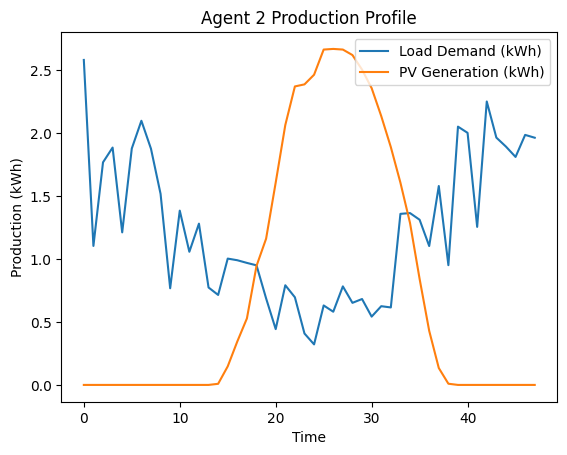

In [ ]:
idx = 2
P2P.env.agent_production_profiles[idx]

plt.plot(P2P.env.agent_consumption_profiles[idx], label='Load Demand (kWh)')
plt.plot(P2P.env.agent_production_profiles[idx], label='PV Generation (kWh)')
plt.xlabel('Time')
plt.ylabel('Production (kWh)')
plt.title(f'Agent {idx} Production Profile')
plt.legend()
plt.show()

In [ ]:
P2P.train()